In [19]:
import numpy as np
import ot
import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap
import cmcrameri.cm as cmc
from tqdm import tqdm
import warnings
%matplotlib widget

In [36]:
def gaussian_feature(coords, mean, std):
    g = np.exp(-np.sum((coords - mean) ** 2, axis=1) / (2 * std**2))
    return g / np.sum(g)


n = 50  # image size
mean = np.array([-0.5, -0.5])  # mean of the Gaussian feature
std = 0.1  # standard deviation of the Gaussian feature

# set up the grid of points
x = np.linspace(-1, 1, 2 * n + 1)
y = np.linspace(-1, 1, 2 * n + 1)
X, Y = np.meshgrid(x, y)
coords = np.array([X.flatten(), Y.flatten()]).T
coords_sqr = np.sum(coords**2, 1)

# compute the cost matrix
M = coords_sqr[:, None] + coords_sqr[None, :] - 2 * coords.dot(coords.T)
M[M < 0] = 0
M = np.sqrt(M)

ts = np.linspace(0, 1, n // 2)  # time steps for moving the Gaussian feature
ds = np.linalg.norm([ts, ts], axis=0)  # distances from the original position

Images = []
WD = []
L2 = []

I0 = gaussian_feature(coords, mean, std)

for t in tqdm(ts, total=len(ts)):
    I = gaussian_feature(coords - t, mean, std)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        wass_dist = ot.emd2(I, I0, M=M)
    WD.append(wass_dist)
    L2.append(np.linalg.norm(I - I0))
    Images.append(I.reshape((2 * n + 1, 2 * n + 1)))

100%|██████████| 25/25 [01:39<00:00,  3.99s/it]


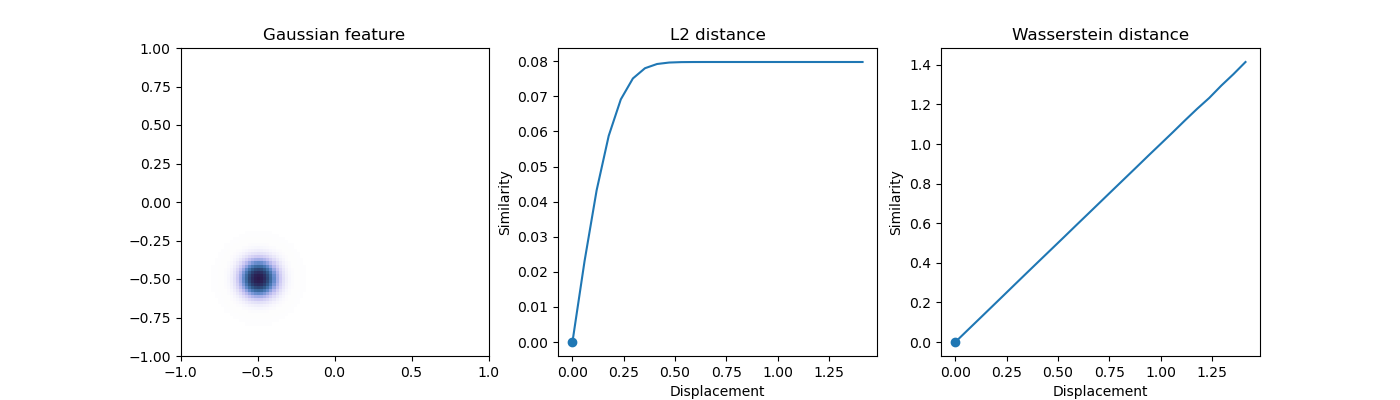

In [40]:

plt.close("all")

# make the alpha channel gradually more transparent so we can see the original image
base_cmap = cmc.devon_r
n_colors = 256
colors = base_cmap(np.linspace(0, 1, n_colors))
for i in range(n_colors):
    colors[i, -1] = i / n_colors
devon_r_transparent = ListedColormap(colors)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

# plot the initial image (twice, because one needs to be updated)
ax1.imshow(
    I0.reshape((2 * n + 1, 2 * n + 1)),
    extent=[-1, 1, -1, 1],
    cmap=devon_r_transparent,
    origin="lower",
)
image = ax1.imshow(
    I0.reshape((2 * n + 1, 2 * n + 1)),
    extent=[-1, 1, -1, 1],
    cmap=devon_r_transparent,
    origin="lower",
)
ax1.set_aspect("equal")
ax1.set_title("Gaussian feature")

# plot the L2 distance
ax2.plot(ds, L2)
l2_stem = ax2.stem(ds[0], L2[0])
ax2.set_xlabel("Displacement")
ax2.set_ylabel("Similarity")
ax2.set_title("L2 distance")

# plot the Wasserstein distance
ax3.plot(ds, WD)
wd_stem = ax3.stem(ds[0], WD[0])
ax3.set_xlabel("Displacement")
ax3.set_ylabel("Similarity")
ax3.set_title("Wasserstein distance")

def update(frame):
    image.set_data(Images[frame])
    l2_stem[0].set_data([ds[frame]], [L2[frame]])
    l2_stem[1].set_segments([[(ds[frame], 0), (ds[frame], L2[frame])]])
    wd_stem[0].set_data([ds[frame]], [WD[frame]])
    wd_stem[1].set_segments([[(ds[frame], 0), (ds[frame], WD[frame])]])
    return [image] + list(l2_stem) + list(wd_stem)

from matplotlib.animation import FuncAnimation, PillowWriter
ani = FuncAnimation(fig, update, frames=len(Images), blit=True)

# save as gif (alternatively use `writer='ffmpeg'` and .mp4 or 'webp')
ani.save("output.gif", writer=PillowWriter(fps=5))
plt.close(fig)
print("Animation saved as output.gif")
